In [2]:
import pickle
import pandas as pd
import numpy as np
import pprint
from bs4 import BeautifulSoup


from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.cluster import DBSCAN


from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import scale



In [3]:
def df_filler(article):
    # Function to construct dataframe row from raw 'article' xml
    
    
    soup = BeautifulSoup(article, 'xml')
    
    try:
        ArticleTitle = soup.find('ArticleTitle').get_text()
    except:
        ArticleTitle = 'NaN'
    try:
        PubYear = soup.find('PubDate').Year.get_text()
    except:
        PubYear = 'NaN'
    try:
        PubMonth = soup.find('PubDate').Month.get_text()
    except:
        PubMonth = 'NaN'
    try:
        PubDay = soup.find('PubDate').Day.get_text()
    except:
        PubDay = 'NaN'
    try:
        Journal = soup.find('Journal').Title.get_text()
    except:
        Journal = 'NaN'
    try:
        Keywords = soup.find('KeywordList').get_text().strip('\n').replace('\n', ',')
    except:
        Keywords = 'NaN'
    try:
        Abstract = soup.find('AbstractText').get_text()
    except:
        Abstract = 'NaN'
    
    row = pd.Series({'ArticleTitle' : ArticleTitle,
                     'PubYear' : PubYear,
                     'PubMonth' : PubMonth,
                     'PubDay' : PubDay,
                     'Journal' : Journal,
                     'Keywords' : Keywords,
                     'Abstract' : Abstract
                    }
                   )
       

    return row

In [4]:
with open('xml_final.pkl', 'rb') as xmlfinal_file:
    pubmed_xml_batch = pickle.load(xmlfinal_file)
xmlfinal_file.close()

In [5]:
pubmed_xml = []

for c,v in enumerate(pubmed_xml_batch):
    pubmed_xml.extend(v.split('\n\n\n'))
#    print(c)
#    print(len(v.split('\n\n\n')))
#    print('\n')

In [6]:
len(pubmed_xml)

71858

In [7]:
df = pd.DataFrame(columns = ['ArticleTitle', 'PubYear', 'PubMonth', 'PubDay', 'Journal', 'Keywords', 'Abstract'])

In [8]:
for article in pubmed_xml:
    row = df_filler(article)
    df = df.append(row, ignore_index = True)

In [9]:
df.shape

(71858, 7)

In [10]:
def PubMonth_to_num(entry):
    if entry == 'Jan':
        return '01'
    elif entry == 'Feb':
        return '02'
    elif entry == 'Mar':
        return '03'
    elif entry == 'Apr':
        return '04'
    elif entry == 'May':
        return '05'
    elif entry == 'Jun':
        return '06'
    elif entry == 'Jul':
        return '07'
    elif entry == 'Aug':
        return '08'
    elif entry == 'Sep':
        return '09'
    elif entry == 'Oct':
        return '10'
    elif entry == 'Nov':
        return '11'
    elif entry == 'Dec':
        return '12'
    elif entry == 'NaN':
        return 'NaN'
    else:
        return entry

df['PubMonthNum'] = df.PubMonth.map(PubMonth_to_num)


# Split off fraction

In [11]:
df.to_csv('df_csv.csv')

In [12]:
large, small = train_test_split(df, test_size = 0.05)

In [13]:
#Split off small section for testing
small.to_csv('df_small.csv')

# Real Modeling

In [14]:
df.shape

(71858, 8)

In [15]:
df_clean_abstract = df[df.Abstract != 'NaN']
df_clean_abs_year= df_clean_abstract[df_clean_abstract.PubYear != 'NaN']#.dropna(axis=0, how='any', subset=['Abstract'])
df_clean_abs_year['PubYearNum'] = df_clean_abs_year.loc[:, 'PubYear'].astype(int)


df_clean = df_clean_abs_year[df_clean_abs_year.PubYearNum >= 1980]

/Users/allandong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
df_grp = df_clean.groupby('PubYear', as_index=True)

yrlst = sorted(list(df_clean.PubYear.unique()))

grp_dct = {}
for year in yrlst:
    abstract_group = df_grp.get_group(year).Abstract
    grp_dct[year] = abstract_group


def vec_abs_over_yrs(vectorizer):
# Creates dict grp_vec of 'year' : 'sparse matrix of vectorized abstracts from that year'


    grp_vec= {}
    for year in yrlst:
        x = vectorizer.fit_transform(grp_dct[year])
        grp_vec[year] = x
    return grp_vec

In [17]:
with open('stop_words_eng.txt', 'r') as f:
    stop_words_eng = f.read().split()
f.close


<function TextIOWrapper.close>

In [18]:
abstracts = df_clean.Abstract

count_vectorizer = CountVectorizer(ngram_range = (0,1), stop_words = 'english')

count = count_vectorizer.fit_transform(abstracts)

tfidf_vectorizer = TfidfVectorizer(ngram_range = (0,1), 
                                   stop_words = 'english', 
#                                   max_df=0.98, 
#                                   min_df=1
                                  )

tfidf = tfidf_vectorizer.fit_transform(abstracts)

In [19]:
grp_tfidf = vec_abs_over_yrs(tfidf_vectorizer)
grp_count = vec_abs_over_yrs(count_vectorizer)



# Add Stop Words from Overall Abstracts

In [20]:
def additional_stop_words(vectorizer, num_words):
    vector_matrix = vectorizer.fit_transform(abstracts)
    nmf_model = NMF(1)
    nmf_model.fit(vector_matrix)
    n_grams = vectorizer.get_feature_names() 
    for r in nmf_model.components_:
        top_matches = sorted([(v,i) for i,v in enumerate(r)])[-num_words:]
        return [n_grams[i[1]] for i in top_matches]

In [21]:
ct_sw = additional_stop_words(count_vectorizer, 150) 
tf_sw = additional_stop_words(tfidf_vectorizer, 150)

count_stopwords = stop_words_eng + ct_sw
tfidf_stopwords = stop_words_eng + tf_sw

stopwords = stop_words_eng + ct_sw + tf_sw

# Revectorize and Run

In [22]:
count_vectorizer_ct = CountVectorizer(ngram_range = (0,1), 
                                      stop_words = count_stopwords
                                     )
count_vectorizer_tf = CountVectorizer(ngram_range = (0,1), 
                                      stop_words = tfidf_stopwords
                                     )
tfidf_vectorizer_ct = TfidfVectorizer(ngram_range = (0,1), 
                                   stop_words = count_stopwords
                                     )
tfidf_vectorizer_tf = TfidfVectorizer(ngram_range = (0,1), 
                                   stop_words = tfidf_stopwords
                                     ) 

count_vectorizer_sw = CountVectorizer(ngram_range = (0,1), 
                                      stop_words = stopwords
                                     )
tfidf_vectorizer_sw = TfidfVectorizer(ngram_range = (0,1), 
                                   stop_words = stopwords
                                     ) 

In [23]:
grp_count_ct = vec_abs_over_yrs(count_vectorizer_ct)
grp_count_tf = vec_abs_over_yrs(count_vectorizer_tf)
grp_tfidf_ct = vec_abs_over_yrs(tfidf_vectorizer_ct)
grp_tfidf_tf = vec_abs_over_yrs(tfidf_vectorizer_tf)

In [24]:
def nmf_topic_gen(matrix, vectorizer, topic_num, papers): 
    vectorizer.fit_transform(papers)
    nmf_model = NMF(1)
    nmf_model.fit(matrix)
    n_grams = vectorizer.get_feature_names()
    for r in nmf_model.components_:
        topic_model = sorted([(v,i) for i,v in enumerate(r)])[-topic_num:]
        return [n_grams[i[1]] for i in topic_model]

In [25]:
def nmf_topic_words(group_vec, vectorizer, topic_num):
    for key in group_vec.keys():
        return(nmf_topic_gen(group_vec[key], vectorizer, topic_num, grp_dct[key]))


In [26]:
grps = [grp_count_ct, 
        grp_count_tf, 
        grp_tfidf_ct, 
        grp_tfidf_tf]
vecs = [count_vectorizer_ct, count_vectorizer_tf, tfidf_vectorizer_ct, tfidf_vectorizer_tf, count_vectorizer_sw, tfidf_vectorizer_sw]

In [27]:
years = yrlst

for yr in years:
    print(str(yr))
    print(nmf_topic_gen(grp_tfidf_tf[yr], tfidf_vectorizer_sw, 3, grp_dct[yr]))
    

    



1980
['combining', 'combination', 'cfuc']
1981
['cfue', 'colorectal', 'cfuc']
1982
['colonisation', 'cfuc', 'combination']
1983
['colonisation', 'assayed', 'colposcopic']
1984
['series', 'colorectal', 'assayed']
1985
['duct', 'assayable', 'column']
1986
['assayed', 'serve', 'du145']
1987
['cfus', 'toxin', 'column']
1988
['colorectal', 'cfuc', 'good']
1989
['colorectal', 'cfuc', 'golden']
1990
['cfuc', 'colorimetric', 'goblet']
1991
['colorectal', 'cfus', 'goiter']
1992
['colorectal', 'cfus', 'goitrogenesis']
1993
['cmml', 'colorectal', 'good']
1994
['cg', 'colour', 'goal']
1995
['alter', 'ddi', 'permits']
1996
['bm5', 'dcc', 'pcna']
1997
['m7', 'permeable', 'ddelta2']
1998
['dbeta2', 'perlecan', 'machinery']
1999
['medium', 'permit', 'dc']
2000
['dbds', 'dbd', 'medically']
2001
['gy', 'medications', 'granule']
2002
['granular', 'doses', 'gynecological']
2003
['dormant', 'granular', 'h1299']
2004
['dorsal', 'granule', 'gynecologic']
2005
['granular', 'trapping', 'gyri']
2006
['granular'

In [28]:

dct_yr_all = []

for yr in yrlst:
    dct_yr = {}
    dct_yr["name"] = str(yr)
    dct_yr_child =[]
    
    
    dct_topic_child = []
    for topic in nmf_topic_gen(grp_tfidf_tf[yr], tfidf_vectorizer_sw, 3, grp_dct[yr]):
        dct_topic = {}
        dct_topic["name"] = topic
        dct_topic["size"] = 800
        dct_topic_child.append(dct_topic)
#    dct_topic_child.append({"name" : yr, "size" : 800})
    dct_yr["children"] = dct_topic_child
    
    dct_yr_all.append(dct_yr)
    
jsondct = {"name" : "Cancer Stem Cell",
           "children" : dct_yr_all}


In [29]:
import json
import pprint
#with open('jsondct.json', 'wb') as f:

pprint.pprint(json.dumps(jsondct, separators = (',', ':')))



('{"name":"Cancer Stem '
 'Cell","children":[{"name":"1980","children":[{"name":"combining","size":800},{"name":"combination","size":800},{"name":"cfuc","size":800}]},{"name":"1981","children":[{"name":"cfue","size":800},{"name":"colorectal","size":800},{"name":"cfuc","size":800}]},{"name":"1982","children":[{"name":"colonisation","size":800},{"name":"cfuc","size":800},{"name":"combination","size":800}]},{"name":"1983","children":[{"name":"colonisation","size":800},{"name":"assayed","size":800},{"name":"colposcopic","size":800}]},{"name":"1984","children":[{"name":"series","size":800},{"name":"colorectal","size":800},{"name":"assayed","size":800}]},{"name":"1985","children":[{"name":"duct","size":800},{"name":"assayable","size":800},{"name":"column","size":800}]},{"name":"1986","children":[{"name":"assayed","size":800},{"name":"serve","size":800},{"name":"du145","size":800}]},{"name":"1987","children":[{"name":"cfus","size":800},{"name":"toxin","size":800},{"name":"column","size":800}]

In [30]:
import seaborn as sbn
import matplotlib.pyplot as plt

%matplotlib inline

In [31]:
amounts = df_clean.PubYear.value_counts()
amounts.index

Index(['2016', '2015', '2014', '2013', '2017', '2012', '2011', '2010', '2009',
       '2008', '2007', '2006', '2005', '2004', '2003', '2002', '2001', '2000',
       '1999', '1996', '1998', '1997', '1995', '1994', '1993', '1992', '1989',
       '1990', '1991', '1985', '1988', '1987', '1986', '1984', '1983', '1982',
       '1981', '1980'],
      dtype='object')

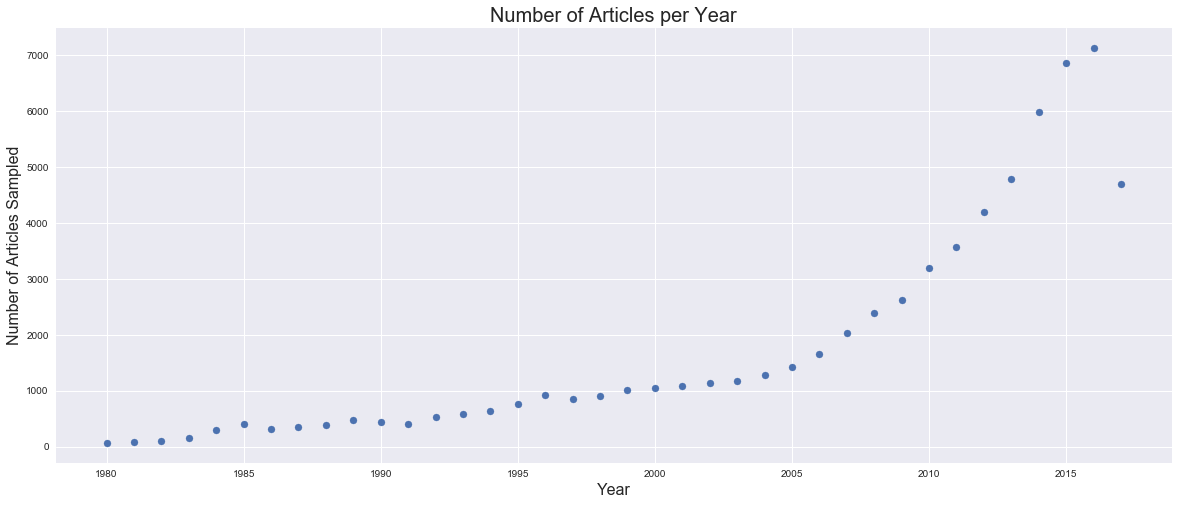

In [32]:
plt.figure(figsize = (20, 8))
plt.scatter(amounts.index, amounts)
plt.title("Number of Articles per Year", size = 20)
plt.xlabel("Year", size=16)
plt.ylabel("Number of Articles Sampled", size=16)

In [33]:
df_clean.shape

(65941, 9)

In [34]:

for i in range(0,len(yrlst)-5):
    years_abstracts = ' '
    for x in range(i, i + 5):
        years_abstracts.join(yrlst[i : i+5])
    print(yrlst[i] + ' - ' + yrlst[i+4])
#    print(nmf_topic_gen(grp_tfidf_tf[years_abstracts], tfidf_vectorizer_sw, 5, grp_dct[yr]))
    

1980 - 1984
1981 - 1985
1982 - 1986
1983 - 1987
1984 - 1988
1985 - 1989
1986 - 1990
1987 - 1991
1988 - 1992
1989 - 1993
1990 - 1994
1991 - 1995
1992 - 1996
1993 - 1997
1994 - 1998
1995 - 1999
1996 - 2000
1997 - 2001
1998 - 2002
1999 - 2003
2000 - 2004
2001 - 2005
2002 - 2006
2003 - 2007
2004 - 2008
2005 - 2009
2006 - 2010
2007 - 2011
2008 - 2012
2009 - 2013
2010 - 2014
2011 - 2015
2012 - 2016
